## BASE ROOT

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\FraudDetectionData.csv")

In [3]:
# Change the data type of column 'A' from float64 to float32
df['amount'] = df['amount'].astype('float32')
df['oldbalanceOrg'] = df['oldbalanceOrg'].astype('float32')
df['oldbalanceDest'] = df['oldbalanceDest'].astype('float32')
df['newbalanceOrig'] = df['newbalanceOrig'].astype('float32')
df['newbalanceDest'] = df['newbalanceDest'].astype('float32')

In [4]:
df['step'] = df['step'].astype('int32')
df['isFlaggedFraud'] = df['isFlaggedFraud'].astype('int32') 
df['isFraud'] = df['isFraud'].astype('int32') 

In [5]:
# Importing LabelEncoder from Sklearn
# library from preprocessing Module.
from sklearn.preprocessing import LabelEncoder
# Creating a instance of label Encoder.
le = LabelEncoder()
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(df['type'])
# printing label
label
# removing the column 'type' from df
# as it is of no use now.
df.drop("type", axis=1, inplace=True)
# Appending the array to our dataFrame
# with column name 'type'
df["type"] = label
# printing Dataframe
#df

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df['nameDest'])
label
df.drop("nameDest", axis=1, inplace=True)
df["nameDest"] = label
#df

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df['nameOrig'])
label
df.drop("nameOrig", axis=1, inplace=True)
df["nameOrig"] = label
#df

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('isFraud', axis=1)
# Separate the target variable
y = df['isFraud']

# Print class distribution before split
print(y.value_counts(normalize=True))

from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=18)

# Print class distribution after split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.998709
1    0.001291
Name: isFraud, dtype: float64
0    0.998709
1    0.001291
Name: isFraud, dtype: float64
0    0.99871
1    0.00129
Name: isFraud, dtype: float64


In [9]:
print("Number of rows in X_train:", X_train.shape[0])
print("Number of rows in X_test:", X_test.shape[0])

Number of rows in X_train: 5726358
Number of rows in X_test: 636262


## Class imbalacnce

In [12]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours,OneSidedSelection

# Assume X_train and y_train are the original training data
# resample using TomekLinks first
tomek_links = TomekLinks(sampling_strategy='auto')
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_train, y_train)

# resample the output of TomekLinks using EditedNearestNeighbours
enn = EditedNearestNeighbours(sampling_strategy='auto')
X_train_resampled_new, y_train_resampled_new = enn.fit_resample(X_train_resampled, y_train_resampled)

In [14]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours,OneSidedSelection
# resample the output of EditedNearestNeighbours using One-Sided Selection
oss = OneSidedSelection(sampling_strategy='auto')
X_train_resampled_final, y_train_resampled_final = oss.fit_resample(X_train_resampled_new, y_train_resampled_new)

In [15]:
import numpy as np
# assuming y_train is a numpy array or a pandas series
counts = np.bincount(y_test)
print("Class 0 count:", counts[0])
print("Class 1 count:", counts[1])

Class 0 count: 635441
Class 1 count: 821


## PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Standardize the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled_final)

# Perform PCA on the training set
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)

# Train the model on the transformed training set
model = RandomForestClassifier()
# Train the model on the transformed training set
model.fit(X_train_pca, y_train_resampled_final)

# Transform the test set using the PCA transformation obtained from the training set
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

# Evaluate the model on the transformed test set
y_pred = model.predict(X_test_pca)
print(classification_report(y_test, y_pred))

# Repeat steps 2-6 for every fold in cross-validation
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train_pca, y_train_resampled_final, cv=cv, scoring='f1_macro')
print("Cross-validation scores: ", scores)
print("Average score: ", scores.mean())

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635441
           1       0.92      0.22      0.35       821

    accuracy                           1.00    636262
   macro avg       0.96      0.61      0.67    636262
weighted avg       1.00      1.00      1.00    636262



## Chosen PCA components

In [ ]:
print('Top 5 Principal Components:\n', pca.components_[:5])
print('Explained Variance Ratio:\n', pca.explained_variance_ratio_[:5])

## ROC curve for each fold

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# create an empty list to store the true positive rates and false positive rates for each fold
tprs = []
fprs = []
aucs = []

# iterate over the cross-validation folds
for train_idx, val_idx in cv.split(X_train_pca, y_train_resampled_final):

    # fit the model on the training set
    model.fit(X_train_pca[train_idx], y_train_resampled_final[train_idx])

    # predict the probabilities on the validation set
    y_prob = model.predict_proba(X_train_pca[val_idx])
    fpr, tpr, thresholds = roc_curve(y_train_resampled_final[val_idx], y_prob[:, 1])
    tprs.append(tpr)
    fprs.append(fpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # plot the ROC curve for each fold
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (len(aucs), roc_auc))

# plot the mean ROC curve across all folds
mean_tpr = np.mean(tprs, axis=0)
mean_fpr = np.linspace(0, 1, 100)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=.8)

# add the diagonal line for reference
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

# set the x and y limits of the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

# set the labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# show the plot
plt.show()

## Plot learning curve

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, log_loss

# Define your scoring metric
scoring_metric = make_scorer(log_loss, greater_is_better=False)

# Define your cross-validation strategy
cv = StratifiedKFold(n_splits=3)

# Calculate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_train_pca, y=y_train_resampled_final,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=cv,
    scoring=scoring_metric,
)

# Calculate the mean and standard deviation of the training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, -train_mean, color='blue', marker='o', markersize=5, label='training log loss')
plt.fill_between(train_sizes, -train_mean - train_std, -train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, -test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation log loss')
plt.fill_between(train_sizes, -test_mean - test_std, -test_mean + test_std, alpha=0.15, color='green')
plt.xlabel('Number of training samples')
plt.ylabel('Log Loss')
plt.legend(loc='lower right')
plt.show()

## Hyperparameter tuning

## Outliers

In [ ]:
import random
import numpy as np
from scipy import stats

# Specify columns with outliers
cols_with_outliers = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Specify the number of bootstrapped samples to create per column
num_samples = 50

# Specify the right trimming proportions for each column
trim_props = {'amount': 0.14, 'oldbalanceOrg': 0.24, 'newbalanceOrig': 0.25, 'oldbalanceDest': 0.22, 'newbalanceDest': 0.22}

# Initialize empty dictionaries to store the trimmed means for each column
train_trimmed_means = {}

# Loop over the specified columns
for col_name in cols_with_outliers:
    
    # Check if the trimming proportion for this column is 0
    if trim_props[col_name] == 0:
        # If so, skip this column and move on to the next one
        continue
    
    # Initialize empty lists to store the bootstrapped samples and the trimmed means for the training set
    train_bootstrapped_samples = []
    train_trimmed_means_list = []
    
    # Loop over the number of desired samples
    for i in range(num_samples):
        # Randomly select indices from the column in the training set
        train_sample_indices = np.random.choice(X_train_resampled_final.index, size=len(X_train_resampled_final), replace=True)
        
        # Create a bootstrapped sample by indexing into the column with the selected indices for the training set
        train_sample = X_train_resampled_final.loc[train_sample_indices, col_name]
        
        # Append the bootstrapped samples to the list for the training set
        train_bootstrapped_samples.append(train_sample)
        
        # Calculate the right trimmed mean of the bootstrapped sample for the training set
        train_right_trimmed_mean = np.mean(train_sample[train_sample <= np.percentile(train_sample, 100*(1-trim_props[col_name]))])
        train_trimmed_means_list.append(train_right_trimmed_mean)
        
    # Calculate the mean of the right trimmed means for the training set and add it to the dictionary
    train_trimmed_means[col_name] = np.mean(train_trimmed_means_list)

    # Replace the outliers in the training set with the trimmed means
    X_train_resampled_final.loc[X_train_resampled_final[col_name] > np.percentile(X_train_resampled_final[col_name], 100*(1-trim_props[col_name])), col_name] = train_trimmed_means[col_name]

# Print the trimmed means for each column separately for the training set
print("Train set trimmed means: ", train_trimmed_means)

## Feature selection

In [ ]:
# Assuming your original training data is stored in a pandas DataFrame called X_train
# And assuming you have a list of selected feature names called selected_features
selected_features = ['oldbalanceOrg', 'type', 'nameDest','amount','step']
X_train_selected = X_train_resampled_final[selected_features]

In [ ]:
X_test_selected=X_test[selected_features]

## Hyperparamter tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Select top features using Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_selected, y_train_resampled_final)

In [ ]:
from scipy.stats import randint as sp_randint
# Define your hyperparameter search space
from scipy.stats import randint
param_dist = { 
    'n_estimators': randint(100, 250),
    'max_features': ['sqrt', 'log2'],
    'min_impurity_decrease': [0, 0.1, 0.2, 0.3],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

In [ ]:
from sklearn.experimental import enable_halving_search_cv  # Required to enable HalvingRandomSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

# Set up the HalvingRandomSearchCV with aggressive early stopping
search = HalvingRandomSearchCV(rf, param_dist, cv=5,verbose=1, 
                               factor=2, resource='n_samples', max_resources=100, 
                               aggressive_elimination=True, random_state=2, 
                               scoring='accuracy', refit=True)

# Fit the HalvingRandomSearchCV object to the data
search.fit(X_train_selected, y_train_resampled_final)

In [ ]:
# Get the best hyperparameters and evaluate on the test set
best_params = search.best_params_
best_model = search.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test_selected)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Best hyperparameters:", best_params)
print("Test set accuracy:", accuracy)

## Model training

Fold: 1
Confusion matrix:
 [[2852198    2008]
 [   1696    2000]]
Recall: 0.5411255411255411
Precision: 0.499001996007984
F1-score: 0.5192107995846312
OOB error: 0.001003883268215655
---------------------
Fold: 2
Confusion matrix:
 [[2852108    2098]
 [   1694    2002]]
Recall: 0.5416666666666666
Precision: 0.48829268292682926
F1-score: 0.5135967162647512
OOB error: 0.0010105315017799876
---------------------


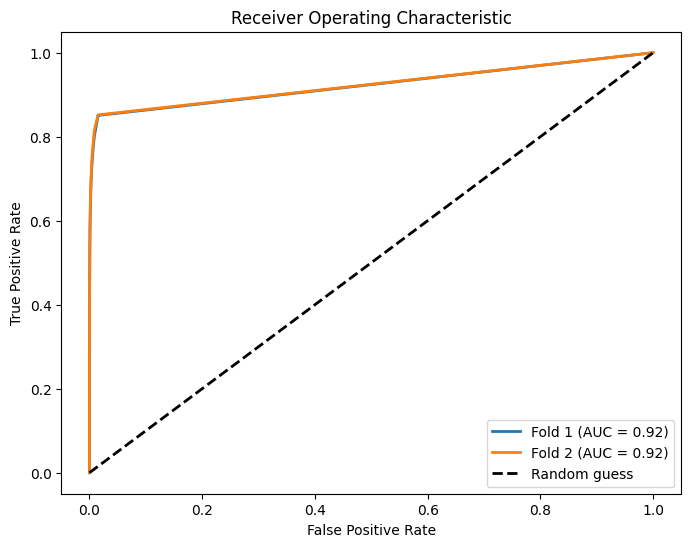

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
import numpy as np

# Define the number of splits for stratified cross-validation
n_splits = 2

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits)

# Create lists to store evaluation metrics for each fold
f1_scores = []
recall_scores = []
precision_scores = []
accuracy_scores = []

# Create lists to store ROC curve data for each fold
fprs = []
tprs = []
aucs = []

# Initialize the OOB error list
oob_error = []

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_selected, y_train_resampled_final)):
    print(f'Fold: {fold+1}')
    
    # Split the data into training and validation sets
    X_fold_train, y_fold_train = X_train_selected.iloc[train_idx], y_train_resampled_final.iloc[train_idx]
    X_val, y_val = X_train_selected.iloc[val_idx], y_train_resampled_final.iloc[val_idx]
    

    # Create a RandomForestClassifier object with the given hyperparameters
    rf_model = RandomForestClassifier(max_features='sqrt',n_estimators=100,oob_score=True)
   
    # Fit the model on the training data
    rf_model.fit(X_fold_train, y_fold_train)

    # Predict the class labels for the validation set
    y_val_pred = rf_model.predict(X_val)
    
    # Predict the class probabilities for the validation set
    y_val_pred_proba = rf_model.predict_proba(X_val)

    # Set the threshold
    threshold = 0.2

    # Convert the probabilities to binary predictions based on the threshold
    y_val_pred = (y_val_pred_proba[:,1] > threshold).astype(int)

    # Compute the evaluation metrics for the current fold
    conf_mat = confusion_matrix(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    # Append the evaluation metrics for the current fold to the lists
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)
    accuracy_scores.append(accuracy)
    
    # Compute the ROC curve and AUC for the current fold
    fpr, tpr, _ = roc_curve(y_val, rf_model.predict_proba(X_val)[:,1])
    roc_auc = auc(fpr, tpr)
    
    # Append the ROC curve data for the current fold to the lists
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)

    # Compute the OOB error for the current fold and append to the list
    oob_error.append(1 - rf_model.oob_score_)

    # Print the evaluation metrics for the current fold
    print('Confusion matrix:\n', conf_mat)
    print('Recall:', recall)
    #print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('F1-score:', f1)
    print('OOB error:', 1 - rf_model.oob_score_)
    print('---------------------')

# Create the ROC curve plot
fig, ax = plt.subplots(figsize=(8,6))

# Plot the ROC curve for each fold
for i in range(n_splits):
    ax.plot(fprs[i], tprs[i], lw=2, label='Fold %d (AUC = %0.2f)' % (i+1, aucs[i]))

# Add a dashed line representing the random guess classifier
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Random guess')

# Add labels and legend to the plot
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend()

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5745816336599366e-06],
 [0.0012903489443028186,
  0.0012903489443028186,
  0.0012903489443028186,
  0.0012903489443028186,
  0.0012903489443028186,
  0.0012903489443028186,
  0.0012903489443028186,
  0.0012903489443028186,
  0.0012903489443028186,
  0.0012211950422938978])

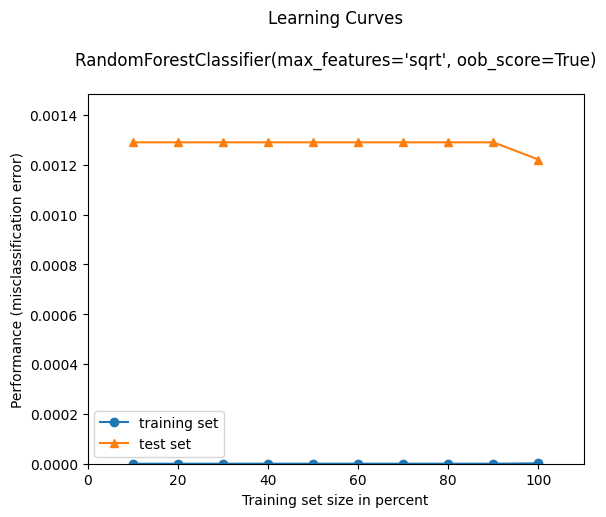

In [20]:
# Load the plot_learning_curves class
from mlxtend.plotting import plot_learning_curves
 
# Plot the learning curves
plot_learning_curves(X_train_selected, y_train_resampled_final, X_test_selected, y_test, rf_model)

## Learning curve

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.model_selection import LearningCurveDisplay, learning_curve

fig, ax = plt.subplots(figsize=(10, 6), sharey=True)

common_params = {
    "X": X_train_selected,
    "y": y_train_resampled_final,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "score_type": "both",
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

estimator = rf_model
LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

ImportError: cannot import name 'LearningCurveDisplay' from 'sklearn.model_selection' (C:\Users\23059\anaconda3\envs\test2\lib\site-packages\sklearn\model_selection\__init__.py)

In [ ]:
# plot_learning_curve(clf, "KNeighborsClassifier", 
#                 X, y, 
#                 train_sizes=np.linspace(.05, 1.0, 5))

## New learning curve

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import learning_curve

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(rf_model,cv=10, scoring='accuracy', train_sizes=np.linspace(0.01, 1.0, 50))
